In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('corrfx.py','wb').write(src)
import corrfx

Saving corrfx.py to corrfx (2).py


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


In [0]:
main='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/'
yieldd='UK_gilt_yield_data.csv'
yield_format='%Y-%m-%d'
ftse='FTSE100_closing_data.csv'
ftse_format='%d/%m/%Y'
inflation='UK_inflation_data.csv'
inflation_format='%Y'
gdp='UK_GDP_data.csv'
gdp_format='%Y'
risk_free_rate='UK_risk_free_rate_data.csv'
risk_free_rate_format=''

url_list=[ftse,yieldd,inflation,gdp,risk_free_rate]
data_type=[1,1,1,1,1]
date_format=[ftse_format,yield_format,inflation_format,gdp_format,risk_free_rate_format]

#creation of our data environment
data_env=corrfx.data_environment(main,url_list,data_type,date_format)

In [0]:
x=data_env.resample_all()
x=x.dropna()

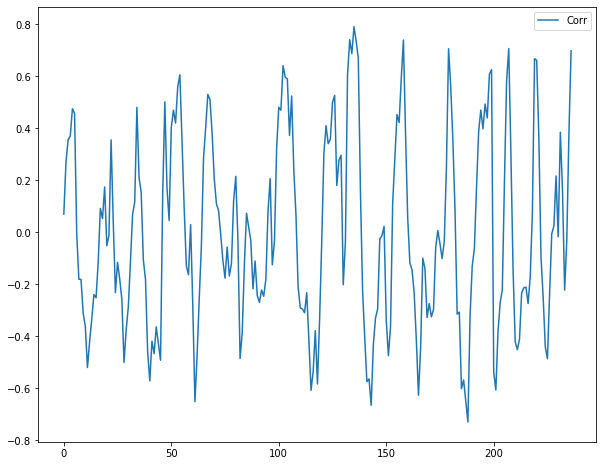

In [6]:
#run 12 month rolling correlations
corr=corrfx.roll_corr(x.iloc[:,1].values,x.iloc[:,2].values,12)
plt.figure(figsize=[10,8])
plt.plot(corr,label="Corr")
plt.legend()
plt.show()

In [0]:
#importing arma models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [0]:
#fn that returns p,q parameters for an ARMA model that would give lowest AIC
def find_lowest_aic(corr):
  '''
  Searches for lowest AIC value for ARMA model of different parameters.
  Returns p,q,lowest_AIC_value
  '''
  p=-1
  q=-1
  lowest_aic=np.inf
  for i in range(0,5):
    for j in range(0,5):
      arma=sm.tsa.ARIMA(corr,order=(i,0,j))
      try:
        arma_fit=arma.fit()
        if arma_fit.aic<lowest_aic:
          p=i
          q=j
          lowest_aic=arma_fit.aic
      except:
        print(i,j,'error')
  return p,q,lowest_aic

In [0]:
#find parameters for all correlations, based on a test set that excludes the last 12 months in the data
length=len(data_env.data)
orders=np.ndarray((length,length),dtype=object)
for i in range(length):
  for j in range(length):
    orders[i,j]=0
    if i==j:
      continue
    if orders[j,i]!=0:
      continue
    corr=corrfx.roll_corr(x.iloc[:,i].values,x.iloc[:,j].values,12)
    corr=corr[:-12]
    p,q,_=find_lowest_aic(corr)
    orders[i,j]=(p,q)
    print(i,j,'complete')

In [26]:
#triangular matrix of the best ARMA orders for each factor's correlations
orders

array([[0, 0, 0, 0, 0],
       [(4, 3), 0, 0, 0, 0],
       [(1, 0), (4, 1), 0, 0, 0],
       [(1, 0), (4, 2), (2, 0), 0, 0],
       [(2, 1), (4, 0), (4, 1), (4, 2), 0]], dtype=object)

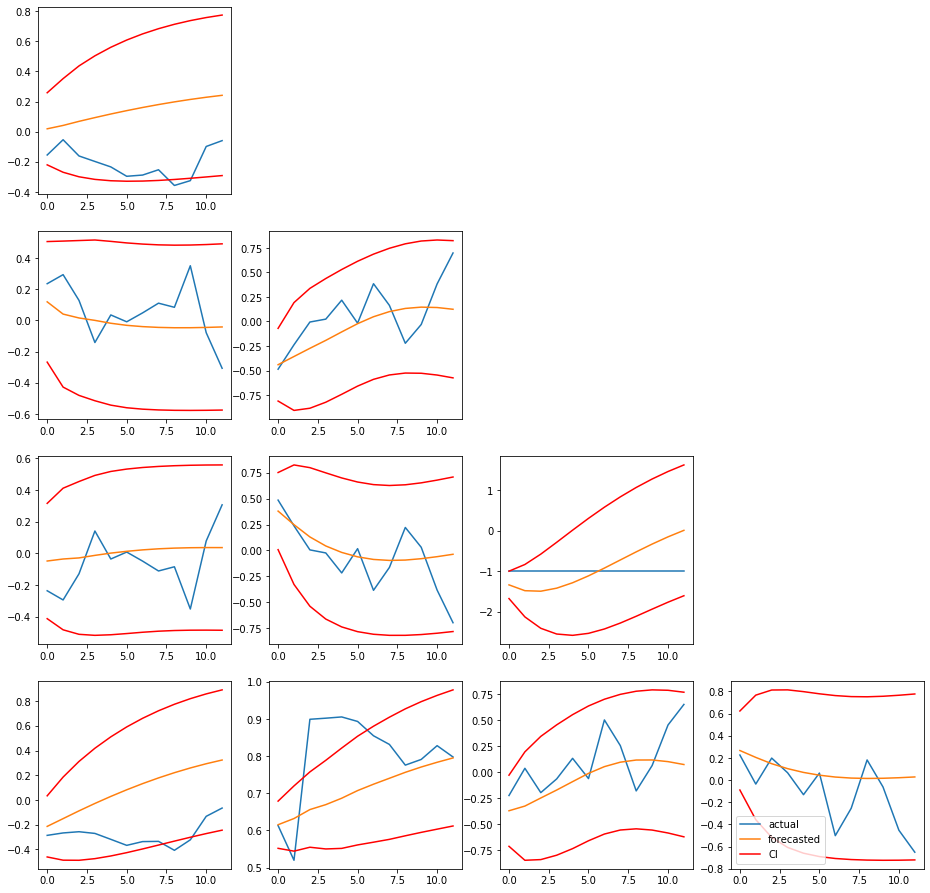

In [101]:
#for each correlation, plot the actual, forecasted and CI 
plt.figure(figsize=[20,20])

for i in range(length):
  for j in range(length):

    if orders[i,j]==0:
      continue
    plt.subplot(5,5,5*i+j+1)
    corr=corrfx.roll_corr(x.iloc[:,i].values,x.iloc[:,j].values,12)
    arma=sm.tsa.ARIMA(corr[:-12],order=(4,0,1))
    arma_fit=arma.fit()
    forecasts=arma_fit.forecast(steps=12)
    plt.plot(corr[-12:],label='actual')
    plt.plot(forecasts[0],label='forecasted')
    plt.plot(forecasts[2][:,0],label='CI',color='red')
    plt.plot(forecasts[2][:,1],color='red')

plt.legend()
plt.savefig('correlations.png',dpi=300)
files.download('correlations.png')
